In [115]:
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot') 

np.random.seed(seed=999)

In [116]:
X = [np.ndarray] * 4
X[0] = stats.chi2(2).rvs(size=100)
X[1] = stats.norm(3, 1).rvs(size=150)
X[2] = stats.uniform(-2, 4).rvs(size=200)
X[3] = stats.norm(5, 1).rvs(size=100)
pooled = np.concatenate(X)

In [117]:
res = pd.DataFrame(index=[f'X{i + 1}' for i in range(len(X))] + ["Pooled"], columns = ["mean", "var", "std"])
for i in range(len(X) + 1):
    if i == len(X):
        res.loc['Pooled', :] = [pooled.mean(), pooled.var(), pooled.std()]
    else:
        res.loc[f'X{i + 1}', :] = [X[i].mean(), X[i].var(), X[i].std()]
        
res

,mean,var,std
X1,2.358265,5.550881,2.356031
X2,2.983326,0.945666,0.972454
X3,-0.11176,1.251382,1.118652
X4,4.812581,1.030817,1.015292
Pooled,2.076784,5.250719,2.291445


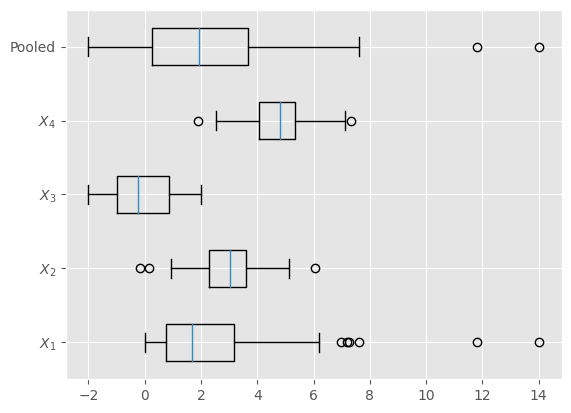

In [118]:
_ = plt.boxplot(X + [pooled], vert=False, labels=[f"$X_{i + 1}$" for i in range(len(X))] + ["Pooled"])

In [119]:
res = stats.bartlett(*X)
print(f"stat: {res.statistic}, pvalue: {res.pvalue}")

stat: 143.7448595642775, pvalue: 5.88744606272854e-31


In [120]:
pooled.size

550

In [121]:
stats.f_oneway(*X)

F_onewayResult(statistic=318.4274244904503, pvalue=1.7897288796137172e-119)

In [122]:
pooled_mean = pooled.mean()

var_bg = 0
for sample in X:
    var_bg += sample.size * (sample.mean() - pooled_mean)**2
var_bg /= pooled.size

var_wg = 0
for sample in X:
    var_wg += sample.size * sample.var()
var_wg /= pooled.size

unbiased_var_bg = pooled.size / (len(X) - 1) * var_bg
unbiased_var_wg = pooled.size / (pooled.size - len(X)) * var_wg
unbiased_var_pooled = np.var(pooled, ddof=1)

print(f"\t\tvar_bg: {var_bg:.3f}, var_wg: {var_wg:.3f}, var_pooled: {pooled.var():.3f}, var_bg + var_wg: {var_bg + var_wg:.3f}")
print(f"unbiased\tvar_bg: {unbiased_var_bg:.3f}, var_wg: {unbiased_var_wg:.3f}, var_pooled: {unbiased_var_pooled:.3f}, var_bg + var_wg: {unbiased_var_bg + unbiased_var_wg:.3f}")
print(f"det_coef^2: {var_bg/var_wg:.3f}, det_coef: {(var_bg/var_wg)**(1/2):.3f}")

		var_bg: 3.341, var_wg: 1.910, var_pooled: 5.251, var_bg + var_wg: 5.251
unbiased	var_bg: 612.533, var_wg: 1.924, var_pooled: 5.260, var_bg + var_wg: 614.457
det_coef^2: 1.750, det_coef: 1.323


group1,group2,meandiff,p-adj,lower,upper,reject
1,2,0.6251,0.0029,0.272,0.9781,True
1,3,-2.47,0.0,-2.8049,-2.1351,True
1,4,2.4543,0.0,2.0676,2.8411,True
2,3,-3.0951,0.0,-3.3905,-2.7997,True
2,4,1.8293,0.0,1.4762,2.1823,True
3,4,4.9243,0.0,4.5894,5.2593,True


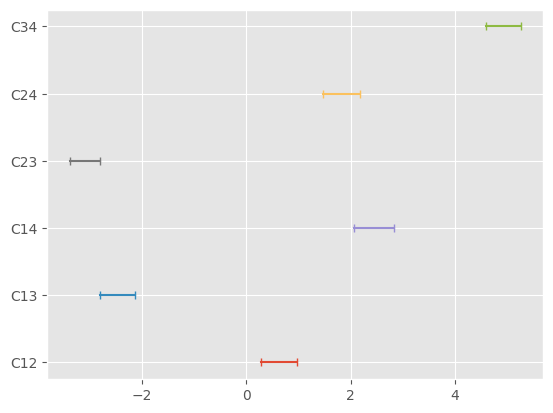

In [123]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

res = pairwise_tukeyhsd(endog=pooled, groups=[i + 1 for i in range(len(X)) for j in range(X[i].size)], alpha=0.2)
display(res.summary())

data = res.summary().data
data.pop(0)
plt.plot(res.confint.T, np.asarray([[i, i] for i in range(res.confint.shape[0])]).T, marker='|')
_ = plt.yticks(range(res.confint.shape[0]), [f'C{row[0]}{row[1]}' for row in data])